## Configuration

In the same folder as this notebook there should be a json file (`config.json`) structured in the following way:

```json
{
    "tba-key": "...",
    
    "events": [
        "tba-key-1",
        "..."
    ],
    
    "cached-data": "file.csv"
}
```

In [8]:
# load config data into dictionary
import json

config_file = "./config.json"

with open(config_file, 'r') as f:
    config_data = json.load(f)

In [9]:
# decompress dictionary into useful variables
tba_key = config_data['tba-key']
events = config_data['events']
cached_data_file = config_data['cached-data']

## Obtain and Cache Data

Query match data from the events listed and save it into a file configured in `config.json`

To requery the data you need to delete the `cached-data` file

In [44]:
# check and see if data is already present, if so then load
import os
import pandas as pd

data_loaded = False

if os.path.isfile(cached_data_file):
    match_df = pd.read_csv(cached_data_file, delim_whitespace=True)
    data_loaded = True
else:
    data_loaded = False

### Querying data from TBA

In [125]:
# establish and ensure a connection can be made with TBA
# (this will fail bc/ the assert if the data is loaded)
assert not data_loaded

import tbapy

tba = tbapy.TBA(tba_key)
assert not tba.status()['is_datafeed_down']

match_df = pd.DataFrame()

# iterate through events and matches and append to dataframe
for event_key in events:
    event_matches = tba.event_matches(event_key)
    for match in event_matches:
        match_df = match_df.append({
            "Event": event_key,
            "Match Type": match.comp_level,
            "Match Number": match.match_number,
            "Match Timestamp": match.actual_time,

            "Blue 1": match.alliances['blue']['team_keys'][0],
            "Blue 2": match.alliances['blue']['team_keys'][1],
            "Blue 3": match.alliances['blue']['team_keys'][2],
            "Blue Cargo Points": match.score_breakdown['blue']['cargoPoints'],
            "Blue Hatch Points": match.score_breakdown['blue']['hatchPanelPoints'],
            "Blue Sandstorm Points": match.score_breakdown['blue']['autoPoints'],
            "Blue Endgame Points": match.score_breakdown['blue']['habClimbPoints'],
            "Blue RP": match.score_breakdown['blue']['rp'],
            "Blue Score": match.score_breakdown['blue']['totalPoints'],

            "Red 1": match.alliances['red']['team_keys'][0],
            "Red 2": match.alliances['red']['team_keys'][1],
            "Red 3": match.alliances['red']['team_keys'][2],
            "Red Cargo Points": match.score_breakdown['red']['cargoPoints'],
            "Red Hatch Points": match.score_breakdown['red']['hatchPanelPoints'],
            "Red Sandstorm Points": match.score_breakdown['red']['autoPoints'],
            "Red Endgame Points": match.score_breakdown['red']['habClimbPoints'],
            "Red RP": match.score_breakdown['red']['rp'],
            "Red Score": match.score_breakdown['red']['totalPoints'],
        }, ignore_index=True)

# save our newly obtained data
match_df.to_csv(cached_data_file, sep=" ", header=True, index=False)

AssertionError: 

In [136]:
# get a list of qualifier matches and team scores
qualifier_matches = match_df.loc[match_df["Match Type"] == 'qm']

team_scores_df = pd.DataFrame()

positions = ["Red 1", "Red 2", "Red 3", "Blue 1", "Blue 2", "Blue 3"]

teams = set()
for p in positions:
    teams |= set(qualifier_matches[p])
    
for team in teams:
    team_scores = []
    for p in positions[:3]:
        team_scores += list(qualifier_matches.loc[qualifier_matches[p] == team]["Red Score"])
    for p in positions[3:]:
        team_scores += list(qualifier_matches.loc[qualifier_matches[p] == team]["Blue Score"])
    team_scores_df = team_scores_df.append({
        "Team": team,
        "Scores": team_scores
    }, ignore_index=True)

## Basic Overview

Here we have some basic plotting and things to just give an overview of what the data looks like.

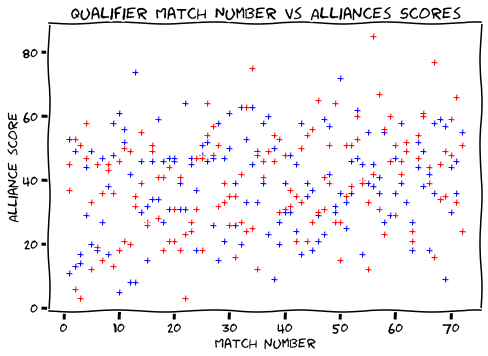

In [79]:
# plot alliance scores vs match number
import matplotlib
import matplotlib.pyplot as plt

plt.xkcd()

fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
ax.set_xlabel("Match number")
ax.set_ylabel("Alliance score")
ax.set_title("Qualifier Match Number vs Alliances Scores")

ax.plot(
    qualifier_matches["Match Number"],
    qualifier_matches["Blue Score"],
    "b+"
)

ax.plot(
    qualifier_matches["Match Number"],
    qualifier_matches["Red Score"],
    "r+",
)

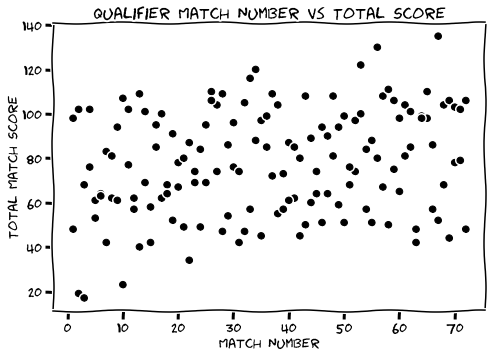

In [90]:
# plot total match score vs match number
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
ax.set_xlabel("Match Number")
ax.set_ylabel("Total Match Score")
ax.set_title("Qualifier Match Number vs Total Score")

ax.plot(
    qualifier_matches["Match Number"],
    qualifier_matches["Blue Score"] + qualifier_matches["Red Score"],
    "ko"
)

## Match Score Distribution Analysis

Here we're going to create a distribution of match score and then look into it from a stats lense

Mean 77.75694444444444, STD 23.778271631358983


<ipython-input-111-14fc1385be57>:18: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(alliance_scores, normed=True)


(array([0.00176554, 0.00117702, 0.01235876, 0.01353578, 0.01059322,
        0.01412429, 0.01177024, 0.01647834, 0.00176554, 0.00117702]),
 array([ 17. ,  28.8,  40.6,  52.4,  64.2,  76. ,  87.8,  99.6, 111.4,
        123.2, 135. ]),
 <a list of 10 Patch objects>)

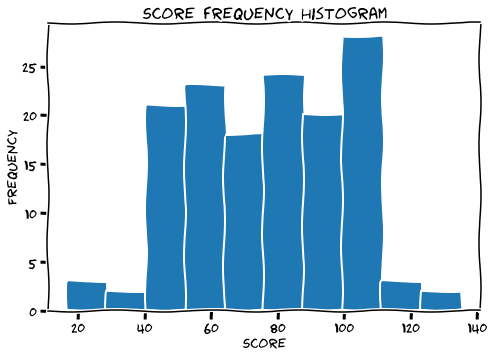

In [111]:
import numpy as np
from scipy import stats

alliance_scores = qualifier_matches["Blue Score"] + qualifier_matches["Red Score"]

mean = np.mean(alliance_scores)
var = np.std(alliance_scores)

print(f"Mean {mean}, STD {var}")

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_xlabel("Score")
ax.set_ylabel("Frequency")
ax.set_title("Score frequency histogram")

ax.hist(alliance_scores)

Quick analysis of the previous graph -- it's so blatantly obviously not a normal distribution.
The next step is to attempt to abuse the CLT with team scores

## Average Team Score Distribution Analysis

That's definitely a normal distribution and the Kolmogorov-Smirnov test seems to back it up (suspiciously well).
Once again, the Central Limit Theorem works, to absolutely nobody's surprise.
Now that we have our average scores and we are pretty confident that it's normal, we can start doing things to teams.

Mean 38.951121794871796, STD 7.764894363657226
Kolmogorov-Smirnov p-val: 0.0


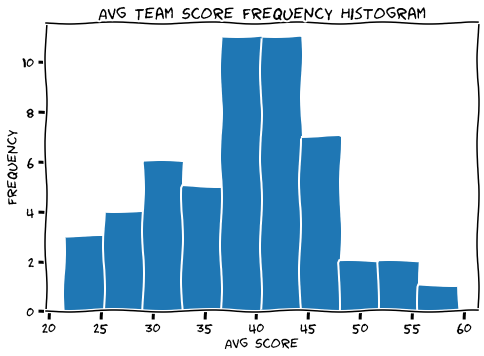

In [188]:
avg_scores_df = pd.DataFrame([
    [team, np.mean(list(team_scores_df.loc[team_scores_df['Team'] == team]['Scores']))]
    for team in teams
])

avg_scores_df.columns = ["Team", "Avg Score"]

avg_scores = avg_scores_df["Avg Score"]

mean, var = np.mean(avg_scores), np.std(avg_scores)

print(f"Mean {mean}, STD {var}")

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_xlabel("Avg Score")
ax.set_ylabel("Frequency")
ax.set_title("Avg Team Score Frequency Histogram")

ax.hist(avg_scores)

_, ks_pval = stats.kstest(avg_scores, 'norm')
print(f"Kolmogorov-Smirnov p-val: {ks_pval}")

### Assigning Score Percentiles to Teams
It's time to discriminate.

~~Facts don't care about your feelings~~

In [187]:
mean, var = np.mean(avg_scores), np.std(avg_scores)

avg_scores_df["Percentile"] = [
    stats.norm.cdf((avg_scores_df.loc[avg_scores_df["Team"] == team]["Avg Score"] - mean) / var)[0]
    for team in avg_scores_df["Team"]
]

avg_scores_df.sort_values(by=["Avg Score"])[::-1]

,Team,Avg Score,Percentile
33,frc4534,59.416667,0.995801
43,frc5544,53.333333,0.968002
38,frc4795,52.166667,0.955619
46,frc5511,48.875000,0.899383
4,frc4829,48.083333,0.880220
50,frc7443,47.583333,0.866866
6,frc7890,47.000000,0.850032
41,frc6729,46.416667,0.831837
21,frc4561,46.333333,0.829126
5,frc2642,45.916667,0.815155
